# 상품 배송 예측
## - 분류 알고리즘 사용
### 1. 데이터 EDA, 전처리
### 2. 모델 생성
### 3. 평가


### 1. 데이터 EDA, 전처리


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler

from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.decomposition import PCA 


from sklearn.metrics import accuracy_score

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
train = pd.read_csv('/content/drive/MyDrive/ML_Practice/03_Product Shipping_ml/Train.csv')
train.shape

(10999, 12)

In [5]:
train.head()

ID Warehouse_block Mode_of_Shipment  Customer_care_calls  Customer_rating  \
0   1               D           Flight                    4                2   
1   2               F           Flight                    4                5   
2   3               A           Flight                    2                2   
3   4               B           Flight                    3                3   
4   5               C           Flight                    2                2   

   Cost_of_the_Product  Prior_purchases Product_importance Gender  \
0                  177                3                low      F   
1                  216                2                low      M   
2                  183                4                low      M   
3                  176                4             medium      M   
4                  184                3             medium      F   

   Discount_offered  Weight_in_gms  Reached.on.Time_Y.N  
0                44           1233                    1  
1                59           3088                    1  
2                48           3374                    1  
3                10           1177                    1  
4                46           2484                    1

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10999 entries, 0 to 10998
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ID                   10999 non-null  int64 
 1   Warehouse_block      10999 non-null  object
 2   Mode_of_Shipment     10999 non-null  object
 3   Customer_care_calls  10999 non-null  int64 
 4   Customer_rating      10999 non-null  int64 
 5   Cost_of_the_Product  10999 non-null  int64 
 6   Prior_purchases      10999 non-null  int64 
 7   Product_importance   10999 non-null  object
 8   Gender               10999 non-null  object
 9   Discount_offered     10999 non-null  int64 
 10  Weight_in_gms        10999 non-null  int64 
 11  Reached.on.Time_Y.N  10999 non-null  int64 
dtypes: int64(8), object(4)
memory usage: 1.0+ MB


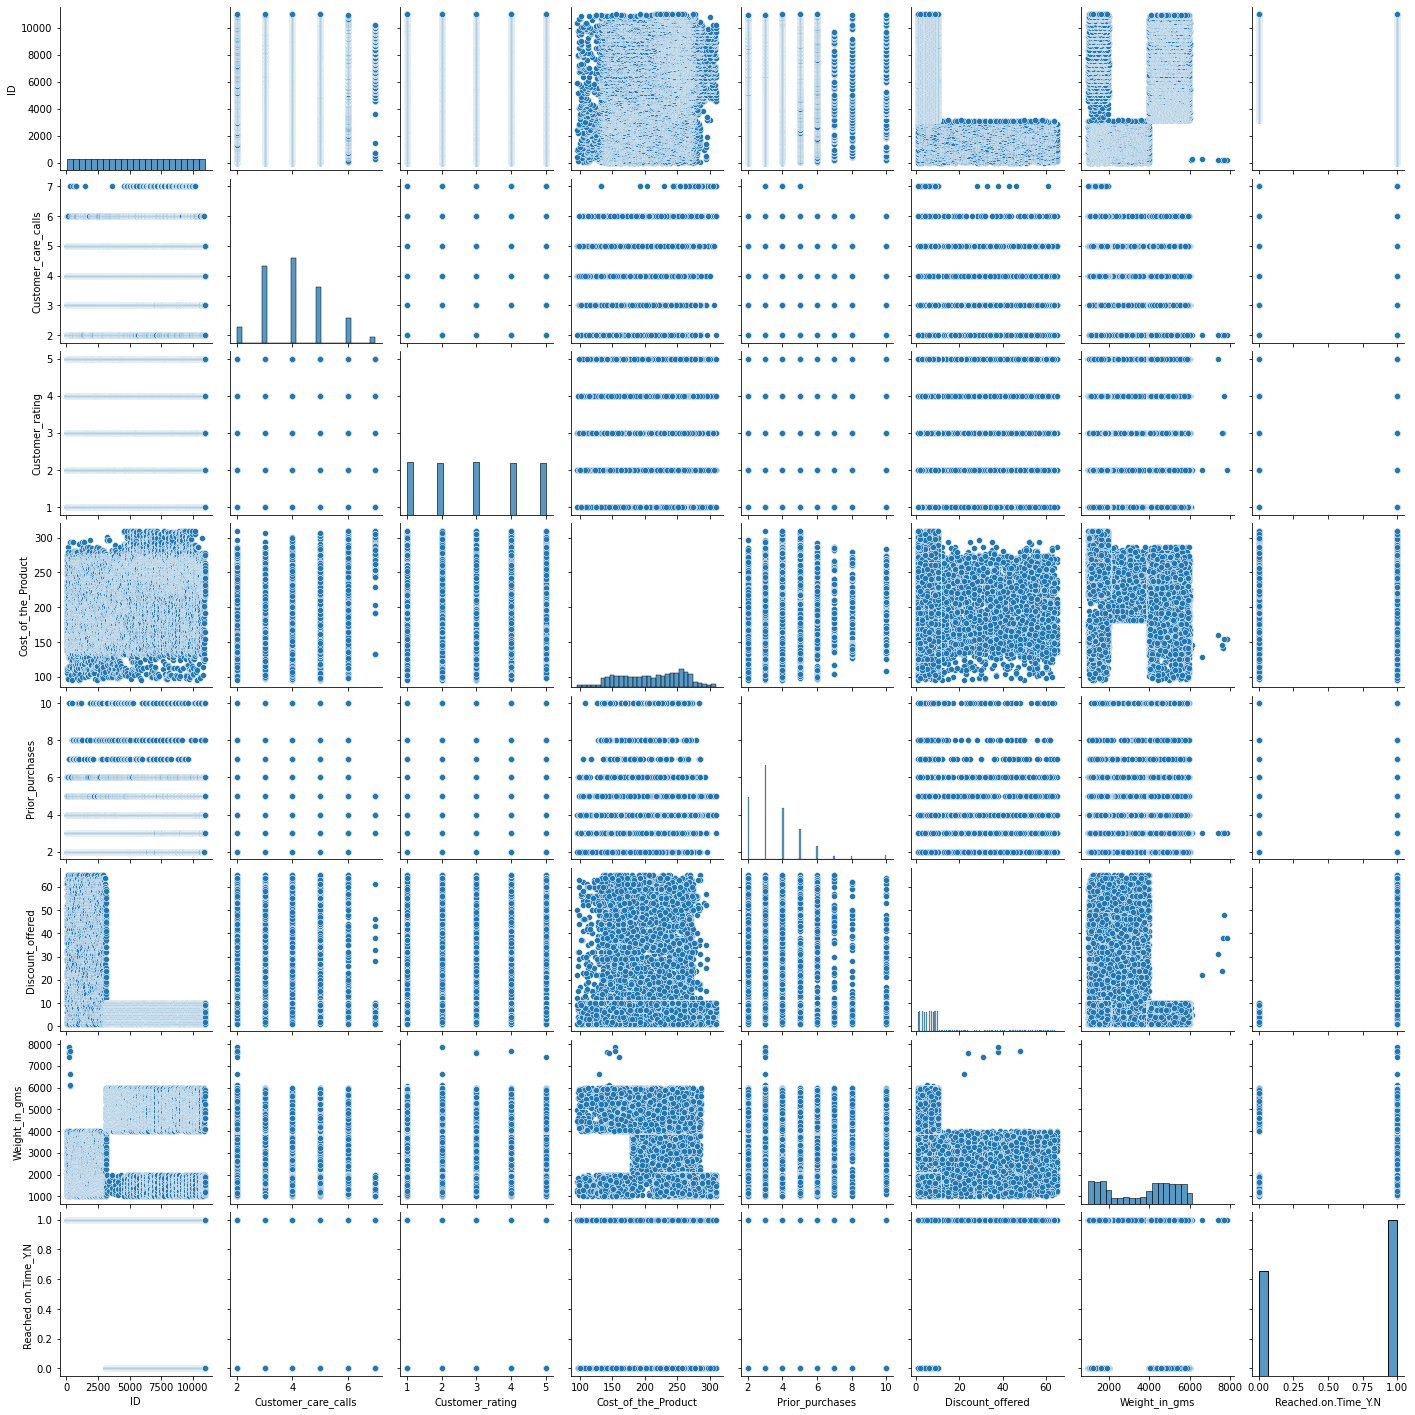

In [8]:
# sns.pairplot(train)

In [9]:
# 결측치 확인

train.isna().sum()

ID                     0
Warehouse_block        0
Mode_of_Shipment       0
Customer_care_calls    0
Customer_rating        0
Cost_of_the_Product    0
Prior_purchases        0
Product_importance     0
Gender                 0
Discount_offered       0
Weight_in_gms          0
Reached.on.Time_Y.N    0
dtype: int64

In [10]:
# 중복 확인

train.duplicated().sum()

0

#### 범주형 데이터 처리

In [19]:
train.select_dtypes('object').columns

Index(['Warehouse_block', 'Mode_of_Shipment', 'Product_importance', 'Gender'], dtype='object')

In [21]:
for col in list(train.select_dtypes('object').columns):
  print(train[col].value_counts())
  print('-'*30)

F    3666
D    1834
A    1833
B    1833
C    1833
Name: Warehouse_block, dtype: int64
------------------------------
Ship      7462
Flight    1777
Road      1760
Name: Mode_of_Shipment, dtype: int64
------------------------------
low       5297
medium    4754
high       948
Name: Product_importance, dtype: int64
------------------------------
F    5545
M    5454
Name: Gender, dtype: int64
------------------------------


- Warehouse_block : 원핫인코딩
- Mode_of_Shipment : 원핫인코딩
- Product_importance : 0,1,2로 인코딩
- Gender : 0,1로 인코딩

In [23]:
train.Gender = train.Gender.map({'M':1, 'F':0})

In [28]:
train.Product_importance = train.Product_importance.map({'low':1, 'medium':2, 'high':3})

In [31]:
Warehouse_one_hot = pd.get_dummies(train.Warehouse_block)

In [34]:
Shipment_one_hot = pd.get_dummies(train.Mode_of_Shipment)

In [37]:
# 원핫인코딩한 데이터 결합 

train.drop(['Warehouse_block','Mode_of_Shipment'], axis=1, inplace = True)

In [39]:
train = pd.concat([train, Warehouse_one_hot,Shipment_one_hot], axis=1)

In [40]:
train.head()

ID  Customer_care_calls  Customer_rating  Cost_of_the_Product  \
0   1                    4                2                  177   
1   2                    4                5                  216   
2   3                    2                2                  183   
3   4                    3                3                  176   
4   5                    2                2                  184   

   Prior_purchases  Product_importance  Gender  Discount_offered  \
0                3                   1       0                44   
1                2                   1       1                59   
2                4                   1       1                48   
3                4                   2       1                10   
4                3                   2       0                46   

   Weight_in_gms  Reached.on.Time_Y.N  A  B  C  D  F  Flight  Road  Ship  
0           1233                    1  0  0  0  1  0       1     0     0  
1           3088                    1  0  0  0  0  1       1     0     0  
2           3374                    1  1  0  0  0  0       1     0     0  
3           1177                    1  0  1  0  0  0       1     0     0  
4           2484                    1  0  0  1  0  0       1     0     0

In [42]:
for col in list(train.columns):
  print(train[col].value_counts())
  print('--'*15)

1        1
7337     1
7329     1
7330     1
7331     1
        ..
3669     1
3670     1
3671     1
3672     1
10999    1
Name: ID, Length: 10999, dtype: int64
------------------------------
4    3557
3    3217
5    2328
6    1013
2     638
7     246
Name: Customer_care_calls, dtype: int64
------------------------------
3    2239
1    2235
4    2189
5    2171
2    2165
Name: Customer_rating, dtype: int64
------------------------------
245    110
257    109
260    106
254    101
264    100
      ... 
107      5
99       5
120      5
96       5
122      4
Name: Cost_of_the_Product, Length: 215, dtype: int64
------------------------------
3     3955
2     2599
4     2155
5     1287
6      561
10     178
7      136
8      128
Name: Prior_purchases, dtype: int64
------------------------------
1    5297
2    4754
3     948
Name: Product_importance, dtype: int64
------------------------------
0    5545
1    5454
Name: Gender, dtype: int64
------------------------------
10    860
2     858
6   

### 데이터 분리


In [45]:
y = train['Reached.on.Time_Y.N']
type(y)

pandas.core.series.Series

In [48]:
X = train.drop(['ID','Reached.on.Time_Y.N'],axis=1)

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1313, test_size = 0.3, stratify=y)
X_train.shape, X_test.shape

((7699, 16), (3300, 16))

#### 스케일링 진행
- Cost_of_the_Product
- Discount_offered
- Weight_in_gms

In [53]:
ss = StandardScaler()
X_train[['Cost_of_the_Product','Discount_offered','Weight_in_gms']] = ss.fit_transform(X_train[['Cost_of_the_Product','Discount_offered','Weight_in_gms']])

In [55]:
X_test[['Cost_of_the_Product','Discount_offered','Weight_in_gms']] = ss.fit_transform(X_test[['Cost_of_the_Product','Discount_offered','Weight_in_gms']])

### 모델 생성
- svm
- LogisticRegression
- RandomForestClassifier
- GradientBoostingClassifier

#### SVM


In [57]:
svm_model = svm.SVC()
svm_model.fit(X_train, y_train)

SVC()

In [58]:
y_pred_svc = svm_model.predict(X_test)
accuracy_score(y_test, y_pred_svc)

0.6590909090909091

#### Logistic

In [61]:
lr = LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression()

In [62]:
y_pred_lr = lr.predict(X_test)
accuracy_score(y_test, y_pred_lr)

0.6345454545454545

#### RF

In [59]:
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)

RandomForestClassifier()

In [60]:
y_pred_rf = rfc.predict(X_test)
accuracy_score(y_test, y_pred_rf)

0.6554545454545454

#### GBC

In [63]:
GBC = GradientBoostingClassifier()
GBC.fit(X_train, y_train)

GradientBoostingClassifier()

In [64]:
y_pred_gbc = GBC.predict(X_test)
accuracy_score(y_test, y_pred_gbc)

0.6803030303030303

#### XGB

In [74]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)

XGBClassifier()

In [72]:
y_test[:5]

7598    0
6041    0
1964    1
4616    0
4918    1
Name: Reached.on.Time_Y.N, dtype: int64

In [83]:
y_pred_xgb = xgb_model.predict_proba(X_test)
accuracy_score(y_test, np.argmax(y_pred_xgb,axis=1))

0.676969696969697

### PCA

In [158]:
pca = PCA(n_components=6)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.fit_transform(X_test)

#### svm

In [109]:
svm_model_pca = svm.SVC()
svm_model_pca.fit(X_train_pca, y_train)

SVC()

In [110]:
y_pred_svc_pca = svm_model_pca.predict(X_test_pca)
accuracy_score(y_test, y_pred_svc_pca)

0.6636363636363637

In [168]:
for i in range(1,13):
  pca = PCA(n_components=i)
  X_train_pca = pca.fit_transform(X_train)
  X_test_pca = pca.fit_transform(X_test)
  svm_model_pca = svm.SVC()
  svm_model_pca.fit(X_train_pca, y_train)
  y_pred_svc_pca = svm_model_pca.predict(X_test_pca)
  print('n_components : ', i)
  print(accuracy_score(y_test, y_pred_svc_pca))
  print('--'*10)

n_components :  1
0.5966666666666667
--------------------
n_components :  2
0.5966666666666667
--------------------
n_components :  3
0.6063636363636363
--------------------
n_components :  4
0.6627272727272727
--------------------
n_components :  5
0.6633333333333333
--------------------
n_components :  6
0.6621212121212121
--------------------
n_components :  7
0.6636363636363637
--------------------
n_components :  8
0.66
--------------------
n_components :  9
0.6609090909090909
--------------------
n_components :  10
0.6593939393939394
--------------------
n_components :  11
0.6584848484848485
--------------------
n_components :  12
0.6606060606060606
--------------------


#### Logistic

In [111]:
lr_pca = LogisticRegression()
lr_pca.fit(X_train_pca, y_train)

LogisticRegression()

In [112]:
y_pred_lr_pca = lr_pca.predict(X_test_pca)
accuracy_score(y_test, y_pred_lr_pca)

0.6406060606060606

In [167]:
for i in range(1,13):
  pca = PCA(n_components=i)
  X_train_pca = pca.fit_transform(X_train)
  X_test_pca = pca.fit_transform(X_test)
  lr_pca = LogisticRegression()
  lr_pca.fit(X_train_pca, y_train)
  y_pred_lr_pca = lr_pca.predict(X_test_pca)
  print('n_components : ', i)
  print(accuracy_score(y_test, y_pred_lr_pca))
  print('--'*10)

n_components :  1
0.5957575757575757
--------------------
n_components :  2
0.5957575757575757
--------------------
n_components :  3
0.5948484848484848
--------------------
n_components :  4
0.6466666666666666
--------------------
n_components :  5
0.6427272727272727
--------------------
n_components :  6
0.6454545454545455
--------------------
n_components :  7
0.6406060606060606
--------------------
n_components :  8
0.6372727272727273
--------------------
n_components :  9
0.6375757575757576
--------------------
n_components :  10
0.6393939393939394
--------------------
n_components :  11
0.6381818181818182
--------------------
n_components :  12
0.6378787878787879
--------------------


#### RF

In [113]:
rfc_pca = RandomForestClassifier()
rfc_pca.fit(X_train_pca, y_train)

RandomForestClassifier()

In [114]:
y_pred_rf_pca = rfc_pca.predict(X_test_pca)
accuracy_score(y_test, y_pred_rf_pca)

0.6457575757575758

In [166]:
for i in range(1,13):
  pca = PCA(n_components=i)
  X_train_pca = pca.fit_transform(X_train)
  X_test_pca = pca.fit_transform(X_test)
  rfc_pca = RandomForestClassifier()
  rfc_pca.fit(X_train_pca, y_train)
  y_pred_rf_pca = rfc_pca.predict(X_test_pca)
  print('n_components : ', i)
  print(accuracy_score(y_test, y_pred_rf_pca))
  print('--'*10)

n_components :  1
0.5275757575757576
--------------------
n_components :  2
0.5415151515151515
--------------------
n_components :  3
0.5872727272727273
--------------------
n_components :  4
0.6381818181818182
--------------------
n_components :  5
0.6551515151515152
--------------------
n_components :  6
0.6518181818181819
--------------------
n_components :  7
0.6460606060606061
--------------------
n_components :  8
0.6512121212121212
--------------------
n_components :  9
0.6430303030303031
--------------------
n_components :  10
0.6424242424242425
--------------------
n_components :  11
0.6521212121212121
--------------------
n_components :  12
0.6493939393939394
--------------------


#### GBC

In [127]:
GBC_pca = GradientBoostingClassifier()
GBC_pca.fit(X_train_pca, y_train)

GradientBoostingClassifier()

In [128]:
y_pred_gbc_pca = GBC_pca.predict(X_test_pca)
accuracy_score(y_test, y_pred_gbc_pca)

0.6481818181818182

In [163]:
for i in range(1,13):
  pca = PCA(n_components=i)
  X_train_pca = pca.fit_transform(X_train)
  X_test_pca = pca.fit_transform(X_test)
  GBC_pca = GradientBoostingClassifier()
  GBC_pca.fit(X_train_pca, y_train)
  y_pred_gbc_pca = GBC_pca.predict(X_test_pca)
  print('n_components : ', i)
  print(accuracy_score(y_test, y_pred_gbc_pca))
  print('--'*10)

n_components :  1
0.5906060606060606
--------------------
n_components :  2
0.5775757575757576
--------------------
n_components :  3
0.5933333333333334
--------------------
n_components :  4
0.6424242424242425
--------------------
n_components :  5
0.6524242424242425
--------------------
n_components :  6
0.6524242424242425
--------------------
n_components :  7
0.6484848484848484
--------------------
n_components :  8
0.6487878787878788
--------------------
n_components :  9
0.6484848484848484
--------------------
n_components :  10
0.6396969696969697
--------------------
n_components :  11
0.6466666666666666
--------------------
n_components :  12
0.6409090909090909
--------------------


#### XGB

In [159]:
xgb_model_pca = XGBClassifier()
xgb_model_pca.fit(X_train_pca, y_train)

XGBClassifier()

In [160]:
y_pred_xgb_pca = xgb_model_pca.predict(X_test_pca)
accuracy_score(y_test, y_pred_xgb_pca)

0.6630303030303031

In [162]:
for i in range(1,13):
  pca = PCA(n_components=i)
  X_train_pca = pca.fit_transform(X_train)
  X_test_pca = pca.fit_transform(X_test)
  xgb_model_pca = XGBClassifier()
  xgb_model_pca.fit(X_train_pca, y_train)
  y_pred_xgb_pca = xgb_model_pca.predict(X_test_pca)
  print('n_components : ', i)
  print(accuracy_score(y_test, y_pred_xgb_pca))
  print('--'*10)

n_components :  1
0.5972727272727273
--------------------
n_components :  2
0.5790909090909091
--------------------
n_components :  3
0.5978787878787879
--------------------
n_components :  4
0.646969696969697
--------------------
n_components :  5
0.656969696969697
--------------------
n_components :  6
0.6630303030303031
--------------------
n_components :  7
0.656060606060606
--------------------
n_components :  8
0.6503030303030303
--------------------
n_components :  9
0.6515151515151515
--------------------
n_components :  10
0.6509090909090909
--------------------
n_components :  11
0.649090909090909
--------------------
n_components :  12
0.6512121212121212
--------------------


### rnn


In [169]:
X_train.shape

(7699, 16)

In [174]:
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf

In [181]:
model = keras.Sequential([
      layers.Dense(64, input_shape = (16,), activation = 'relu'),
      layers.Dense(32, activation = 'relu'),
      layers.Dense(32, activation = 'relu'),
      layers.Dense(1, activation = 'sigmoid')
])

In [182]:
model.compile(loss='binary_crossentropy', # 다중분류 loss : categorical_crossentropy
              optimizer = 'adam',
              metrics = ['acc'])  

In [183]:
history = model.fit(X_train, y_train, epochs=30, batch_size=32,
                    validation_split = 0.2)

Epoch 1/30
193/193 [==============================] - 1s 4ms/step - loss: 0.5630 - acc: 0.6443 - val_loss: 0.5593 - val_acc: 0.5968
Epoch 2/30
193/193 [==============================] - 1s 3ms/step - loss: 0.5290 - acc: 0.6509 - val_loss: 0.5333 - val_acc: 0.6571
Epoch 3/30
193/193 [==============================] - 1s 3ms/step - loss: 0.5234 - acc: 0.6595 - val_loss: 0.5355 - val_acc: 0.6539
Epoch 4/30
193/193 [==============================] - 1s 3ms/step - loss: 0.5213 - acc: 0.6589 - val_loss: 0.5311 - val_acc: 0.6701
Epoch 5/30
193/193 [==============================] - 1s 3ms/step - loss: 0.5185 - acc: 0.6665 - val_loss: 0.5313 - val_acc: 0.6649
Epoch 6/30
193/193 [==============================] - 1s 3ms/step - loss: 0.5158 - acc: 0.6654 - val_loss: 0.5287 - val_acc: 0.6740
Epoch 7/30
193/193 [==============================] - 1s 3ms/step - loss: 0.5149 - acc: 0.6715 - val_loss: 0.5336 - val_acc: 0.6331
Epoch 8/30
193/193 [==============================] - 1s 3ms/step - loss: 0.

In [184]:
model.evaluate(X_test,y_test)

104/104 [==============================] - 0s 2ms/step - loss: 0.5502 - acc: 0.6576


[0.5502049326896667, 0.657575786113739]